# Installing Required Libraries

In [1]:
!pip install torch torchvision cleanvision scikit-learn matplotlib numpy onnx opencv-python-headless pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Importing Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from google.colab import drive
import shutil
from cleanvision import Imagelab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparameters  (changed batch size to 128 from 64 and learning rate to 0.0001 from 0.001)

In [31]:
image_size = 224
num_classes = 12
num_epochs = 10
batch_size = 128
learning_rate = 0.0001

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Directories

In [33]:
# Directories
train_dir = "/content/drive/MyDrive/I2V/cleaned_train"
val_dir = "/content/drive/MyDrive/I2V/val"
output_dir = "/content/drive/MyDrive/I2V/EfficientNet2"
# metrics_file = os.path.join(output_dir, "training_metrics.txt")
os.makedirs(output_dir, exist_ok=True)

In [34]:
# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [35]:
# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Loading pre-trained efficientnet_b0

In [36]:
import torchvision.models as models
import torch.nn as nn

# Load pre-trained EfficientNet (using B0 variant as an example)
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

In [37]:
# Loss and optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Initialize metrics


In [38]:
# Function to compute mAP (simplified for multi-class classification)
def compute_map(true_labels, pred_probs, num_classes):
    # Convert to binary relevance (one-hot encoded true labels)
    true_labels_one_hot = np.zeros((len(true_labels), num_classes))
    for i, label in enumerate(true_labels):
        true_labels_one_hot[i, label] = 1

    # Compute Average Precision per class and mean
    average_precisions = []
    for c in range(num_classes):
        true_c = true_labels_one_hot[:, c]
        scores_c = pred_probs[:, c]
        if true_c.sum() == 0:  # Skip if no positive instances
            continue
        sorted_indices = np.argsort(scores_c)[::-1]
        true_c_sorted = true_c[sorted_indices]
        precision_at_k = np.cumsum(true_c_sorted) / (np.arange(len(true_c_sorted)) + 1)
        ap = np.sum(precision_at_k * true_c_sorted) / max(true_c.sum(), 1)
        average_precisions.append(ap)

    return np.mean(average_precisions) if average_precisions else 0.0

In [39]:
def compute_metrics(true_labels, pred_labels, pred_probs, epoch, save_file):
    accuracy = 100 * (true_labels == pred_labels).mean()
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    m_ap = compute_map(true_labels, pred_probs, num_classes)
    cm = confusion_matrix(true_labels, pred_labels)

    metrics_str = (
        f"Validation Metrics - Epoch {epoch+1}:\n"
        f"Accuracy: {accuracy:.2f}%\n"
        f"Precision: {precision:.4f}\n"
        f"Recall: {recall:.4f}\n"
        f"F1 Score: {f1:.4f}\n"
        f"mAP: {m_ap:.4f}\n"
        f"Confusion Matrix:\n{cm}\n\n"
    )
    print(metrics_str)

    with open(save_file, 'a') as f:
        f.write(metrics_str)

    return accuracy, cm

In [40]:
# Training loop with learning curves
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0

In [41]:
# Initialize metrics file
with open(os.path.join(output_dir, "training_metrics.txt"), 'w') as f:
    f.write("Training Metrics Log\n\n")

In [42]:
metrics_file = "/content/drive/MyDrive/I2V/EfficientNet2/training_metrics.txt"

# Training and Validation

In [43]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        # EfficientNet returns only one output (no aux_outputs)
        outputs = model(images)
        # Compute loss for the single output
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_true = []
    val_pred = []
    val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Single output
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            _, predicted = torch.max(outputs, 1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(predicted.cpu().numpy())
            val_probs.extend(probs)

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_acc, cm = compute_metrics(np.array(val_true), np.array(val_pred), np.array(val_probs), epoch, metrics_file)
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, os.path.join(output_dir, "efficientnet_b0_best.pt"))
        print(f"Saved best model with Validation Accuracy: {val_acc:.2f}%")

Epoch [1/10], Train Loss: 2.2066
Validation Metrics - Epoch 1:
Accuracy: 59.48%
Precision: 0.5649
Recall: 0.5948
F1 Score: 0.5679
mAP: 0.4197
Confusion Matrix:
[[101   2   0   1   1   0   5   1   0   0  17   9]
 [  5  43   0   0   0   0   1  16   0   0   4   0]
 [  3   0  20   0   0   0   5   0   0   0  35   8]
 [  2   2   1   0   1   0   2   4   0   0   8  15]
 [  3   0   0   0   0   0   2   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [ 14   0   1   0   0   0  68   0   0   0   9  10]
 [  2  12   0   0   1   0   0  52   0   0   2   0]
 [  0   1   0   0   0   0   4   2   0   0   5   0]
 [  0   0   0   0   0   0   1   0   0   0   2   0]
 [ 24   1   7   0   0   0  10   0   0   0 102  13]
 [  9   0   0   0   0   0   7   0   0   0  18  69]]


Validation Loss: 1.8184
Saved best model with Validation Accuracy: 59.48%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [2/10], Train Loss: 1.5832
Validation Metrics - Epoch 2:
Accuracy: 69.54%
Precision: 0.6515
Recall: 0.6954
F1 Score: 0.6666
mAP: 0.6343
Confusion Matrix:
[[119   0   0   0   0   0   2   1   0   0  15   0]
 [  1  61   0   0   0   0   0   7   0   0   0   0]
 [  2   0  36   0   0   0   6   1   0   0  25   1]
 [  3   1   2   0   0   0   0   7   0   0   8  14]
 [  6   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [ 11   0   0   0   0   0  76   0   0   0  11   4]
 [  0  14   0   0   0   0   0  55   0   0   0   0]
 [  2   2   0   0   0   0   2   5   0   0   1   0]
 [  0   0   0   0   0   0   1   0   0   0   2   0]
 [ 26   2   6   0   0   0  11   1   0   0 104   7]
 [  5   0   0   0   0   0   1   0   0   0  16  81]]


Validation Loss: 1.1883
Saved best model with Validation Accuracy: 69.54%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [3/10], Train Loss: 1.0831
Validation Metrics - Epoch 3:
Accuracy: 75.16%
Precision: 0.7450
Recall: 0.7516
F1 Score: 0.7259
mAP: 0.7471
Confusion Matrix:
[[113   0   2   0   0   0   3   3   0   0  16   0]
 [  0  60   0   0   1   0   0   8   0   0   0   0]
 [  2   0  45   0   0   0   5   1   0   0  17   1]
 [  3   0   3   2   0   0   0   5   0   0   6  16]
 [  4   0   0   0   1   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  5   0   2   0   0   0  85   0   0   0   6   4]
 [  0   2   0   0   0   0   0  67   0   0   0   0]
 [  1   2   0   0   0   0   3   5   0   0   1   0]
 [  0   0   0   0   0   0   1   0   0   0   2   0]
 [ 16   2  13   0   0   0  12   0   0   0 108   6]
 [  2   0   1   0   0   0   2   0   0   0   4  94]]


Validation Loss: 0.8476
Saved best model with Validation Accuracy: 75.16%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [4/10], Train Loss: 0.7977
Validation Metrics - Epoch 4:
Accuracy: 78.04%
Precision: 0.7772
Recall: 0.7804
F1 Score: 0.7591
mAP: 0.8190
Confusion Matrix:
[[112   0   2   0   0   0   3   1   0   0  19   0]
 [  0  65   0   0   1   0   0   3   0   0   0   0]
 [  1   0  49   0   0   0   5   1   0   0  14   1]
 [  2   0   4   3   0   0   0   4   0   0   7  15]
 [  2   0   0   0   3   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  4   0   1   0   0   0  87   0   0   0   6   4]
 [  0   6   0   0   0   0   0  63   0   0   0   0]
 [  1   5   0   0   1   0   3   2   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   2   0   0]
 [  5   2  14   0   0   0  13   0   0   0 116   7]
 [  2   0   1   0   0   0   1   0   0   0   2  97]]


Validation Loss: 0.6715
Saved best model with Validation Accuracy: 78.04%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [5/10], Train Loss: 0.5922
Validation Metrics - Epoch 5:
Accuracy: 80.26%
Precision: 0.7914
Recall: 0.8026
F1 Score: 0.7906
mAP: 0.8989
Confusion Matrix:
[[118   0   2   0   0   0   2   1   0   0  14   0]
 [  0  61   0   0   1   0   0   7   0   0   0   0]
 [  3   0  52   0   0   0   5   0   0   0  10   1]
 [  2   0   3  14   0   0   0   5   0   0   4   7]
 [  2   0   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  5   0   1   1   0   0  87   0   0   0   4   4]
 [  0   0   0   0   0   0   0  69   0   0   0   0]
 [  2   5   0   0   2   0   2   1   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   2   0   0]
 [ 11   2  14   0   0   0  12   0   0   1 111   6]
 [  2   0   1   0   0   0   1   0   0   0   3  96]]


Validation Loss: 0.5720
Saved best model with Validation Accuracy: 80.26%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [6/10], Train Loss: 0.4684
Validation Metrics - Epoch 6:
Accuracy: 84.05%
Precision: 0.8272
Recall: 0.8405
F1 Score: 0.8309
mAP: 0.9173
Confusion Matrix:
[[120   0   2   0   0   0   2   1   0   0  12   0]
 [  0  69   0   0   0   0   0   0   0   0   0   0]
 [  2   0  54   1   0   0   2   0   0   0  10   2]
 [  2   0   1  20   0   0   0   5   0   0   3   4]
 [  1   0   0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  3   0   1   1   1   0  87   0   0   0   6   3]
 [  0   3   0   0   0   0   0  66   0   0   0   0]
 [  1   5   0   0   3   0   2   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [ 12   2   9   0   0   0   6   0   0   0 121   7]
 [  2   0   1   0   0   0   1   0   0   0   1  98]]


Validation Loss: 0.4926
Saved best model with Validation Accuracy: 84.05%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [7/10], Train Loss: 0.3748
Validation Metrics - Epoch 7:
Accuracy: 84.71%
Precision: 0.8325
Recall: 0.8471
F1 Score: 0.8386
mAP: 0.9340
Confusion Matrix:
[[119   0   2   0   0   0   1   1   0   0  13   1]
 [  0  65   0   0   0   0   0   4   0   0   0   0]
 [  1   0  56   1   0   0   2   0   0   0   9   2]
 [  1   0   1  28   0   0   0   1   0   0   3   1]
 [  1   0   0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  3   0   1   1   1   0  89   0   0   0   3   4]
 [  0   0   0   0   0   0   0  69   0   0   0   0]
 [  1   5   0   0   3   0   2   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [ 11   2  10   3   1   0  10   0   0   0 115   5]
 [  1   0   1   0   0   0   1   0   0   0   1  99]]


Validation Loss: 0.4441
Saved best model with Validation Accuracy: 84.71%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [8/10], Train Loss: 0.2859
Validation Metrics - Epoch 8:
Accuracy: 85.88%
Precision: 0.8626
Recall: 0.8588
F1 Score: 0.8535
mAP: 0.9416
Confusion Matrix:
[[121   0   1   0   0   0   0   1   0   0  13   1]
 [  0  63   0   0   0   0   0   6   0   0   0   0]
 [  1   0  56   1   0   0   2   0   0   0   9   2]
 [  2   0   1  27   0   0   0   1   0   0   4   0]
 [  1   0   0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  3   0   1   1   1   0  91   0   0   0   3   2]
 [  0   0   0   0   1   0   0  68   0   0   0   0]
 [  2   2   0   0   4   0   2   1   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [ 10   1  10   2   1   0   7   0   0   0 123   3]
 [  1   0   1   0   0   0   1   0   0   0   1  99]]


Validation Loss: 0.4084
Saved best model with Validation Accuracy: 85.88%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [9/10], Train Loss: 0.2335
Validation Metrics - Epoch 9:
Accuracy: 87.06%
Precision: 0.8725
Recall: 0.8706
F1 Score: 0.8655
mAP: 0.9461
Confusion Matrix:
[[122   0   1   0   0   0   0   1   0   0  12   1]
 [  0  65   0   0   0   0   0   4   0   0   0   0]
 [  2   0  59   1   0   0   1   0   0   0   6   2]
 [  2   0   1  27   0   0   0   1   0   0   4   0]
 [  0   0   0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  2   0   1   1   1   0  92   0   0   0   3   2]
 [  0   1   0   0   0   0   0  68   0   0   0   0]
 [  0   5   0   0   3   0   2   0   2   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [ 10   1  12   1   1   0   6   0   0   0 121   5]
 [  1   0   1   0   0   0   0   0   0   0   0 101]]


Validation Loss: 0.3908
Saved best model with Validation Accuracy: 87.06%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [10/10], Train Loss: 0.1800
Validation Metrics - Epoch 10:
Accuracy: 87.06%
Precision: 0.8714
Recall: 0.8706
F1 Score: 0.8665
mAP: 0.9483
Confusion Matrix:
[[121   0   0   0   0   0   1   1   0   0  13   1]
 [  0  65   0   0   0   0   0   4   0   0   0   0]
 [  2   0  57   1   0   0   1   0   0   0   8   2]
 [  2   0   0  30   0   0   0   0   0   0   3   0]
 [  1   0   0   0   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  1   0   1   1   1   0  93   0   0   0   3   2]
 [  0   0   0   0   1   0   0  68   0   0   0   0]
 [  1   4   0   0   2   0   2   0   3   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0]
 [ 13   1   8   2   1   0   7   0   0   0 120   5]
 [  1   0   1   0   0   0   0   0   0   0   0 101]]


Validation Loss: 0.3808


# Accuracy

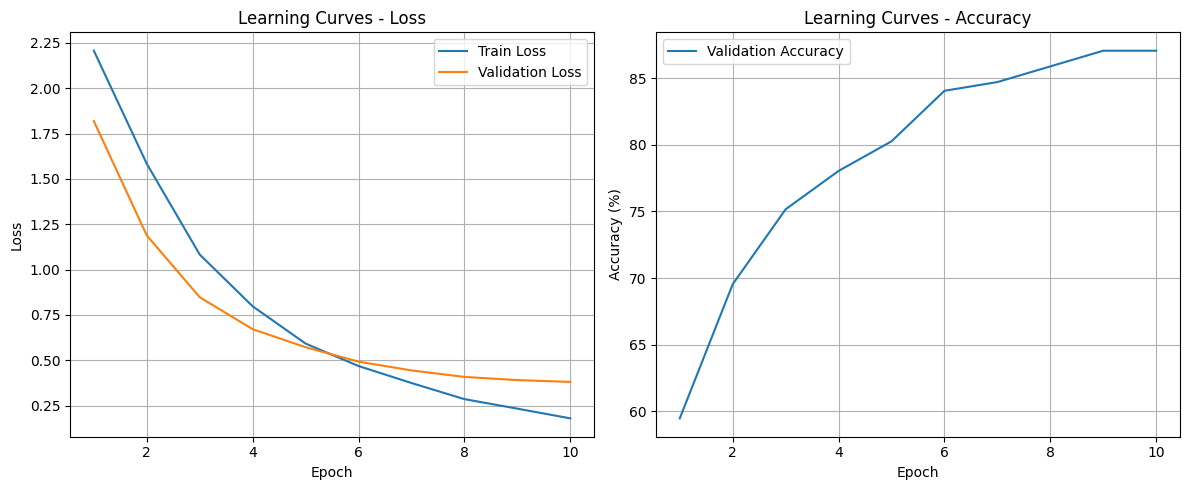

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves - Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curves - Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "learning_curves.png"))
plt.show()

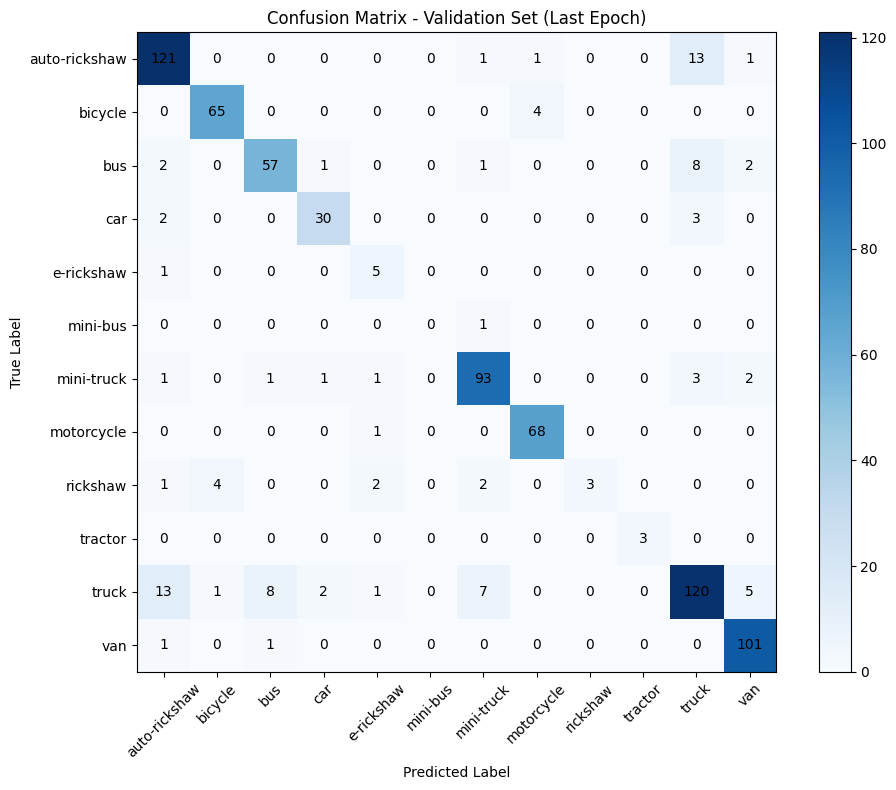

Training complete. Best Validation Accuracy: 87.06%


In [45]:
# Plot confusion matrix (using the last epoch's validation CM)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set (Last Epoch)')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, val_dataset.classes, rotation=45)
plt.yticks(tick_marks, val_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

print(f"Training complete. Best Validation Accuracy: {best_val_acc:.2f}%")

# Saving Model

In [46]:
# Use an image size compatible with Inception V3 (299x299)
dummy_input = torch.randn(1, 3, image_size, image_size).to(device)
torch.onnx.export(
    model,
    dummy_input,
    os.path.join(output_dir, "efficientnet_b0_best2.onnx"),
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11,
)
print("Model exported to ONNX")

Model exported to ONNX
